In [130]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util
import utils.math_utils as math_util
import math
import utils.latex_utils as tex
from scipy import stats
import utils.time_series_utils as ts_util
import json
import utils.measurement_utils as m_util

In [131]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.32-24


In [132]:
used_dut_name = [
    'workstationtwo',
    # 'workstationone',
]

used_dut_name.sort()

used_dut_env = 'prod'

windows = "win32nt"
linux = "unix"

used_os_names = [
    windows, 
    linux
]

used_test_case_names = [
    'fannkuch-redux.exe',
    # 'mandelbrot.exe',
    # 'idle-case.exe'
]

used_test_case_names.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"
rapl = "rapl"
clamp = "clamp"
plug = "plug"
scaphandre = "scaphandre"

windows_mi = [
    ipg, lhm, clamp, plug, scaphandre
]

linux_mi = [
    rapl, clamp, plug
]

used_mi_names = [
    ipg ##ipg, lhm, ipg, clamp, plug #, scaphandre, # plug, rapl
]

ipg_sample_rate = 100
lhm_sample_rate = 100
rapl_sample_rate = 100
clamp_sample_rate = 100
plug_sample_rate = 200
scaphandre_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]
used_compilers = [
    'intel-one-api'
]

test_case_parameters = ["", "12", "16000"]

experiment_name = "same-one-api-compiler-different-measuring-instruments-post-update-and-watt"
experiment_number = 2

used_allocated_cores.sort()
used_mi_names.sort()
used_compilers.sort()

In [133]:
used_dut_name_str = "','".join(used_dut_name)
used_os_name_str = "','".join(used_os_names)
dut = rep.get_devices_under_test(db)
dut.shape

(7, 4)

In [134]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}') and Os in ('{used_os_name_str}')")
used_dut.shape

(1, 4)

In [135]:
tc = rep.get_test_cases(db)
tc.shape

(30, 8)

In [136]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)
used_test_case_parameters = "','".join(test_case_parameters)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}') and Parameter in ('{used_test_case_parameters}')")

In [137]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

In [138]:
mi = rep.get_measuring_instruments(db)

mi.shape

(15, 3)

In [139]:
used_mi_query_list =  query.get_mi_query(
    used_mi_names,
    ipg,
    lhm,
    rapl,
    plug,
    clamp,
    scaphandre,
    ipg_sample_rate,
    lhm_sample_rate,
    rapl_sample_rate,
    plug_sample_rate,
    clamp_sample_rate,
    scaphandre_sample_rate,
)

used_mi = mi.query(" or ".join(used_mi_query_list))

In [140]:
used_allocated_cores_str = ",".join([str(x) for x in used_allocated_cores])
used_allocated_cores_str = used_allocated_cores_str.replace("'", '')
used_allocated_cores_str = used_allocated_cores_str.replace("[", "'[")
used_allocated_cores_str = used_allocated_cores_str.replace("]", "]'")

In [141]:
config = rep.get_configurations(db)

config.shape

(15, 5)

In [142]:
config.shape

(15, 5)

In [143]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ({used_allocated_cores_str})")
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [144]:
exp = rep.get_distinct_experiments(db)

exp.shape

(7, 2)

In [145]:
for i in range(0, 1001, 100):
    print(i)

0
100
200
300
400
500
600
700
800
900
1000


In [146]:
data_to_plot = {}

for i in range(100, 701, 100):
    cpu_energy_results = {}
    dram_energy_results = {}
    gpu_energy_results = {}
    duration_results = {}

    idle_cpu_consumption_results = {}

    cpu_dynamic_energy_watt_consumption = {}

    cpu_dynamic_energy_consumption = {}
    gpu_dynamic_energy_consumption = {}
    dram_dynamic_energy_consumption = {}

    temperature_begin = {}
    temperature_end = {}

    m_util.get_measurements(
        windows,
        windows_mi,
        linux,
        linux_mi,
        used_configs,
        used_dut,
        used_mi,
        used_tc,
        used_idle_case,
        db,
        experiment_name,
        experiment_number,
        # energy_per_time,
        scaphandre,
        cpu_energy_results,
        dram_energy_results,
        gpu_energy_results,
        duration_results,
        temperature_begin,
        temperature_end,
        cpu_dynamic_energy_consumption,
        gpu_dynamic_energy_consumption,
        dram_dynamic_energy_consumption,
        idle_cpu_consumption_results,
        used_test_case_name,
        cpu_dynamic_energy_watt_consumption
    )
    
    for key, value in cpu_dynamic_energy_consumption.items():
        cpu_dynamic_energy_consumption[key] = value[:i]
    
    for k in cpu_dynamic_energy_consumption.keys():
        data_to_plot[k + "." +str(i)] = cpu_dynamic_energy_consumption[k]

Y - fannkuch-redux.exe.win32nt.workstationtwo.all.intel-one-api.ipg.100.4
Y - fannkuch-redux.exe.win32nt.workstationtwo.all.intel-one-api.ipg.100.4
Y - fannkuch-redux.exe.win32nt.workstationtwo.all.intel-one-api.ipg.100.4
Y - fannkuch-redux.exe.win32nt.workstationtwo.all.intel-one-api.ipg.100.4
Y - fannkuch-redux.exe.win32nt.workstationtwo.all.intel-one-api.ipg.100.4
Y - fannkuch-redux.exe.win32nt.workstationtwo.all.intel-one-api.ipg.100.4
Y - fannkuch-redux.exe.win32nt.workstationtwo.all.intel-one-api.ipg.100.4


In [147]:
def convert_to_series(df):
    for key in df.keys():
        df[key] = pd.Series(df[key])
    return df

In [148]:
data_to_plot = convert_to_series(data_to_plot)
data_df = pd.DataFrame(data_to_plot)
data_df = data_df.reindex(columns=sorted(data_df.columns))

Duration of Test Case


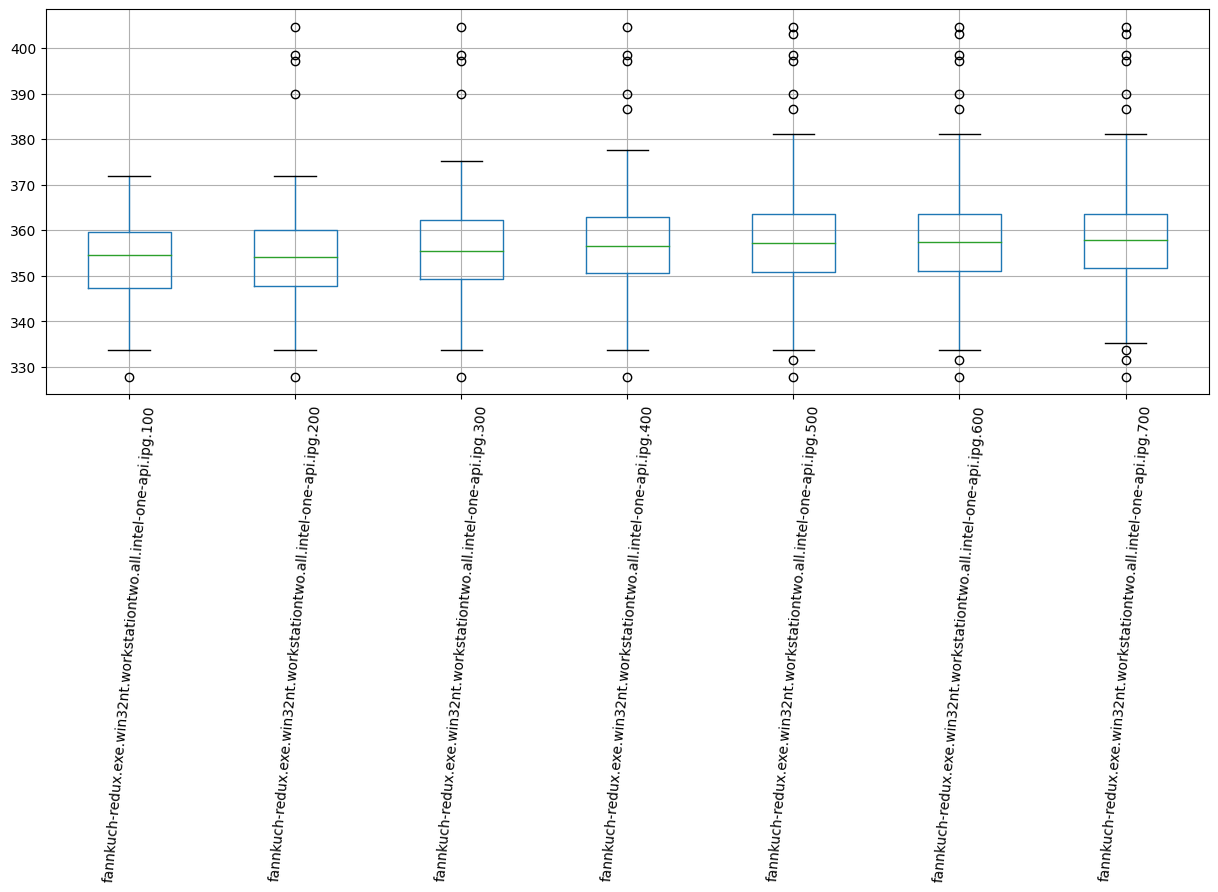

In [149]:
print("Duration of Test Case")
boxplot = data_df.boxplot(figsize=(15,5), rot=85)
boxplot.plot()
# plot.ylim(0,40)
plot.show()